# 🐾 PawMI - Análisis de Datasets y PyCaret
## Selección de dataset y algoritmo para el chat de salud

**Objetivo:** Usar PyCaret para probar múltiples algoritmos con un subset pequeño de datos y seleccionar el mejor para entrenar manualmente después.

## 1️⃣ Importar librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print('Librerías importadas')

✅ Librerías importadas


## 📦 Dataset Sintético - 5000 Registros

**ACTUALIZACIÓN:** Ahora usaremos el dataset sintético generado con 5000 registros de perros y gatos, perfecto para entrenar modelos robustos.

In [ ]:
# Cargar dataset sintético
synthetic_data_path = Path('../data/synthetic/sinteticos')
df_synthetic = pd.read_csv(synthetic_data_path / 'synthetic_animal_disease_prediction_dog_cat_5000_no_header.csv')

print('Dataset sintético cargado')
print(f'Shape: {df_synthetic.shape}')
print(f'\nColumnas:')
print(df_synthetic.columns.tolist())
print(f'\nPrimeras filas:')
display(df_synthetic.head())
print(f'\nDistribución de especies:')
print(df_synthetic['Animal_Type'].value_counts())
print(f'\nDistribución de enfermedades:')
print(df_synthetic['Disease_Prediction'].value_counts())
print(f'\nEstadísticas básicas:')
print(f'Total registros: {len(df_synthetic)}')
print(f'Enfermedades únicas: {df_synthetic["Disease_Prediction"].nunique()}')
print(f'Razas únicas: {df_synthetic["Breed"].nunique()}')

### 🧹 Limpieza y Preprocesamiento del Dataset Sintético

In [ ]:
# Hacer una copia para trabajar
df = df_synthetic.copy()

print('Limpiando datos...')

# 1. Limpiar Body_Temperature (quitar °C y convertir a float)
if 'Body_Temperature' in df.columns:
    df['Body_Temperature'] = df['Body_Temperature'].str.replace('Â°C', '').str.replace('°C', '').astype(float)
    print('Body_Temperature limpiado')

# 2. Convertir variables Yes/No a 1/0
binary_cols = ['Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing', 
               'Labored_Breathing', 'Lameness', 'Skin_Lesions', 
               'Nasal_Discharge', 'Eye_Discharge']

for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

print(f'{len(binary_cols)} columnas binarias convertidas')

# 3. Ver valores nulos
print(f'\nValores nulos:')
null_counts = df.isnull().sum()
if null_counts.sum() > 0:
    print(null_counts[null_counts > 0])
else:
    print('   ¡No hay valores nulos!')

# 4. Ver duplicados
duplicates = df.duplicated().sum()
print(f'\nDuplicados: {duplicates}')

# 5. Info del dataset limpio
print(f'\nDataset limpio:')
print(f'hape: {df.shape}')
print(f'Columnas: {len(df.columns)}')
print(f'Tipos de datos:')
print(df.dtypes.value_counts())

# 6. Mostrar muestra de datos limpios
print(f'\nMuestra de datos limpios:')
display(df.head())

### 🎯 Preparación de Datos para Machine Learning

In [ ]:
# Seleccionar features relevantes para ML
# No incluimos Symptom_1, Symptom_2, etc. porque ya tenemos las columnas binarias específicas

features_ml = [
    # Demografía
    'Animal_Type', 'Age', 'Gender', 'Weight',
    
    # Síntomas (binarios)
    'Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing',
    'Labored_Breathing', 'Lameness', 'Skin_Lesions',
    'Nasal_Discharge', 'Eye_Discharge',
    
    # Signos vitales
    'Body_Temperature', 'Heart_Rate',
    
    # Target
    'Disease_Prediction'
]

# Crear dataset ML
df_ml = df[features_ml].copy()

# Eliminar filas con NaN (si hay alguna)
df_ml = df_ml.dropna()

print('Dataset ML preparado')
print(f'\nInformación:')
print(f'Registros: {df_ml.shape[0]}')
print(f'Features: {df_ml.shape[1] - 1} (+ 1 target)')
print(f'Enfermedades: {df_ml["Disease_Prediction"].nunique()}')

print(f'\nTop 10 enfermedades:')
disease_dist = df_ml['Disease_Prediction'].value_counts()
print(disease_dist.head(10))

print(f'\nDistribución Animal_Type:')
print(df_ml['Animal_Type'].value_counts())

print(f'\nColumnas finales para ML:')
for i, col in enumerate(df_ml.columns, 1):
    col_type = 'TARGET' if col == 'Disease_Prediction' else 'Feature'
    print(f'   {i:2d}. {col:20s} - {col_type}')

## 🤖 Comparación de Algoritmos ML con Dataset Completo (5000 registros)

Ahora con **5000 registros** podemos entrenar modelos robustos y comparar múltiples algoritmos.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print('Preparando datos para entrenamiento...')

# Separar features y target
X = df_ml.drop('Disease_Prediction', axis=1)
y = df_ml['Disease_Prediction']

# Codificar variables categóricas
le_animal = LabelEncoder()
le_gender = LabelEncoder()

X_processed = X.copy()
X_processed['Animal_Type'] = le_animal.fit_transform(X['Animal_Type'])
X_processed['Gender'] = le_gender.fit_transform(X['Gender'])

# Normalizar features numéricas
scaler = StandardScaler()
numeric_features = ['Age', 'Weight', 'Body_Temperature', 'Heart_Rate']
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])

print(f'Datos preprocesados:')
print(f'Features shape: {X_processed.shape}')
print(f'Target shape: {y.shape}')
print(f'Clases únicas: {y.nunique()}')

# Split train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f'\nSplit de datos:')
print(f'Train: {X_train.shape[0]} registros ({X_train.shape[0]/len(X_processed)*100:.1f}%)')
print(f'Test:  {X_test.shape[0]} registros ({X_test.shape[0]/len(X_processed)*100:.1f}%)')

# Definir algoritmos a probar
algorithms = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
    'SVM (RBF)': SVC(random_state=42, kernel='rbf'),
    'K-Neighbors (k=5)': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10)
}

print(f'\nListos para entrenar {len(algorithms)} algoritmos...')

### 📊 Entrenar y Comparar Modelos

In [ ]:
import time

# Ejecutar comparación de algoritmos
results = {}
trained_models = {}

print('ENTRENANDO Y EVALUANDO MODELOS')
print('='*70)

for name, algorithm in algorithms.items():
    print(f'\n {name}...')
    start_time = time.time()
    
    # Cross-validation (5-fold)
    print('Cross-validation (5-fold)...', end=' ')
    cv_scores = cross_val_score(algorithm, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    print(f'Done!')
    
    # Entrenar en todo el conjunto de entrenamiento
    print('  Entrenando modelo final...', end=' ')
    algorithm.fit(X_train, y_train)
    print(f'Done!')
    
    # Predicciones en test set
    y_pred = algorithm.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # Calcular tiempo
    elapsed_time = time.time() - start_time
    
    # Guardar resultados
    results[name] = {
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'Test_Accuracy': test_accuracy,
        'Train_Time': elapsed_time
    }
    
    # Guardar modelo entrenado
    trained_models[name] = algorithm
    
    print(f'CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Tiempo: {elapsed_time:.2f}s')

print('RANKING FINAL')

# Ordenar por CV accuracy
sorted_results = sorted(results.items(), key=lambda x: x[1]['CV_Mean'], reverse=True)

print(f'\n{"Rank":<6} {"Modelo":<25} {"CV Accuracy":<15} {"Test Accuracy":<15} {"Tiempo":<10}')
print('-'*70)

for i, (name, metrics) in enumerate(sorted_results, 1):
    cv_acc = f"{metrics['CV_Mean']:.4f} ±{metrics['CV_Std']:.4f}"
    test_acc = f"{metrics['Test_Accuracy']:.4f}"
    train_time = f"{metrics['Train_Time']:.2f}s"
    
    emoji = '🏆' if i == 1 else '🥈' if i == 2 else '🥉' if i == 3 else '  '
    print(f'{emoji} #{i:<4} {name:<25} {cv_acc:<15} {test_acc:<15} {train_time:<10}')

# Mejor modelo
best_name = sorted_results[0][0]
best_metrics = sorted_results[0][1]
best_model = trained_models[best_name]

print('\n' + '='*70)
print(f'MEJOR MODELO: {best_name}')
print('='*70)
print(f'CV Accuracy: {best_metrics["CV_Mean"]:.4f} (±{best_metrics["CV_Std"]:.4f})')
print(f'Test Accuracy: {best_metrics["Test_Accuracy"]:.4f}')
print(f'Tiempo de entrenamiento: {best_metrics["Train_Time"]:.2f}s')

## 2️⃣ Cargar y explorar los 3 datasets

In [ ]:
# Rutas de los datasets
data_path = Path('../data/raw')

# Dataset 1: Pet Health Symptoms (Síntomas generales)
df_symptoms = pd.read_csv(data_path / 'pet-health-symptoms-dataset.csv')

# Dataset 2: Animal Disease Prediction (Predicción de enfermedades)
df_diseases = pd.read_csv(data_path / 'cleaned_animal_disease_prediction.csv')

# Dataset 3: Veterinary Clinical Data (Datos clínicos)
df_clinical = pd.read_csv(data_path / 'veterinary_clinical_data.csv')

print('Datasets cargados')
print(f'Síntomas: {df_symptoms.shape}')
print(f'Enfermedades: {df_diseases.shape}')
print(f'Clínico: {df_clinical.shape}')

✅ Datasets cargados
📊 Síntomas: (2000, 3)
📊 Enfermedades: (431, 22)
📊 Clínico: (10000, 10)


### 🔍 Dataset 1: Pet Health Symptoms

In [ ]:
print('=== DATASET 1: PET HEALTH SYMPTOMS ===')
print(f'\nShape: {df_symptoms.shape}')
print(f'\nColumnas:')
print(df_symptoms.columns.tolist())
print(f'\nPrimeras filas:')
display(df_symptoms.head())
print(f'\nInfo:')
df_symptoms.info()
print(f'\nValores únicos en "condition":')
print(df_symptoms['condition'].value_counts())

=== DATASET 1: PET HEALTH SYMPTOMS ===

📏 Shape: (2000, 3)

📋 Columnas:
['text', 'condition', 'record_type']

👁️ Primeras filas:


,text,condition,record_type
0,Barium study performed to evaluate motility an...,Digestive Issues,Clinical Notes
1,Assess deep pain sensation in paralyzed limbs.,Mobility Problems,Clinical Notes
2,Implement regular turning schedule and padded ...,Mobility Problems,Clinical Notes
3,Rule out extra-GI causes of vomiting (renal co...,Digestive Issues,Clinical Notes
4,Baermann technique used to recover lungworm la...,Parasites,Clinical Notes



📊 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         2000 non-null   object
 1   condition    2000 non-null   object
 2   record_type  2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB

🎯 Valores únicos en "condition":
condition
Digestive Issues     400
Mobility Problems    400
Parasites            400
Ear Infections       400
Skin Irritations     400
Name: count, dtype: int64


### 🔍 Dataset 2: Animal Disease Prediction

In [4]:
print('=== DATASET 2: ANIMAL DISEASE PREDICTION ===')
print(f'\n📏 Shape: {df_diseases.shape}')
print(f'\n📋 Columnas:')
print(df_diseases.columns.tolist())
print(f'\n👁️ Primeras filas:')
display(df_diseases.head())
print(f'\n📊 Info:')
df_diseases.info()
print(f'\n🎯 Enfermedades únicas:')
print(df_diseases['Disease_Prediction'].value_counts())

=== DATASET 2: ANIMAL DISEASE PREDICTION ===

📏 Shape: (431, 22)

📋 Columnas:
['Animal_Type', 'Breed', 'Age', 'Gender', 'Weight', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Duration', 'Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing', 'Labored_Breathing', 'Lameness', 'Skin_Lesions', 'Nasal_Discharge', 'Eye_Discharge', 'Body_Temperature', 'Heart_Rate', 'Disease_Prediction']

👁️ Primeras filas:


,Animal_Type,Breed,Age,Gender,Weight,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Duration,...,Diarrhea,Coughing,Labored_Breathing,Lameness,Skin_Lesions,Nasal_Discharge,Eye_Discharge,Body_Temperature,Heart_Rate,Disease_Prediction
0,Dog,Labrador,4,Male,25.0,Fever,Lethargy,Appetite Loss,Vomiting,3 days,...,No,No,No,No,No,No,No,39.5°C,120,Parvovirus
1,Cat,Siamese,2,Female,4.5,Coughing,Sneezing,Eye Discharge,Nasal Discharge,1 week,...,No,Yes,No,No,No,Yes,Yes,38.9°C,150,Upper Respiratory Infection
2,Cow,Holstein,3,Female,600.0,Fever,Nasal Discharge,Labored Breathing,Coughing,5 days,...,No,Yes,Yes,No,No,Yes,No,40.1°C,90,Foot and Mouth Disease
3,Dog,Beagle,1,Male,10.0,Diarrhea,Vomiting,Lethargy,Appetite Loss,2 days,...,Yes,No,No,No,No,No,No,39.2°C,130,Gastroenteritis
4,Cat,Persian,5,Male,3.8,Lethargy,Appetite Loss,Skin Lesions,No,2 weeks,...,No,No,No,No,Yes,No,No,38.7°C,160,Fungal Infection



📊 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Animal_Type         431 non-null    object 
 1   Breed               431 non-null    object 
 2   Age                 431 non-null    int64  
 3   Gender              431 non-null    object 
 4   Weight              431 non-null    float64
 5   Symptom_1           431 non-null    object 
 6   Symptom_2           431 non-null    object 
 7   Symptom_3           431 non-null    object 
 8   Symptom_4           431 non-null    object 
 9   Duration            431 non-null    object 
 10  Appetite_Loss       431 non-null    object 
 11  Vomiting            431 non-null    object 
 12  Diarrhea            431 non-null    object 
 13  Coughing            431 non-null    object 
 14  Labored_Breathing   431 non-null    object 
 15  Lameness            431 non-null    object 
 16 

### 🔍 Dataset 3: Veterinary Clinical Data

In [5]:
print('=== DATASET 3: VETERINARY CLINICAL DATA ===')
print(f'\n📏 Shape: {df_clinical.shape}')
print(f'\n📋 Columnas:')
print(df_clinical.columns.tolist())
print(f'\n👁️ Primeras filas:')
display(df_clinical.head())
print(f'\n📊 Info:')
df_clinical.info()
print(f'\n🐾 Tipos de animales:')
print(df_clinical['AnimalName'].value_counts())

=== DATASET 3: VETERINARY CLINICAL DATA ===

📏 Shape: (10000, 10)

📋 Columnas:
['AnimalName', 'Breed', 'Age', 'Weight_kg', 'MedicalHistory', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5']

👁️ Primeras filas:


,AnimalName,Breed,Age,Weight_kg,MedicalHistory,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
0,Dog,Rottweiler,6.0,32.1,Chronic illness,Anorexia,Hydrophobia,drooping ears,Diarrhea,Shyness or aggression
1,Dog,Bulldog,9.9,18.5,Vaccinated,Lethargy,Weakness,Horny growth,Fever,Coughing
2,Dog,Beagle,13.9,18.9,Parasite history,Pain,Weight loss,Weight loss,Sneezing,Drop on egg production
3,cat,Scottish Fold,5.8,6.3,Recent surgery,Vomiting,Pain,Edema in lower jaw,Pain,Weakness
4,cat,Persian,11.2,4.9,Recent surgery,Severe,Weight loss,Egg production stops,Weakness,Poor Body condition



📊 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AnimalName      10000 non-null  object 
 1   Breed           10000 non-null  object 
 2   Age             10000 non-null  float64
 3   Weight_kg       10000 non-null  float64
 4   MedicalHistory  10000 non-null  object 
 5   Symptom_1       10000 non-null  object 
 6   Symptom_2       10000 non-null  object 
 7   Symptom_3       10000 non-null  object 
 8   Symptom_4       10000 non-null  object 
 9   Symptom_5       10000 non-null  object 
dtypes: float64(2), object(8)
memory usage: 781.4+ KB

🐾 Tipos de animales:
AnimalName
Dog    5020
cat    4980
Name: count, dtype: int64


## 3️⃣ Análisis: ¿Cuál dataset usar para el chat de salud?

### Evaluación de cada dataset:

In [6]:
print('🎯 EVALUACIÓN DE DATASETS PARA CHAT DE SALUD')
print('='*60)

print('\n📊 DATASET 1: Pet Health Symptoms')
print('✅ Pros:')
print('   - Texto libre ("text") - Ideal para NLP/Chat')
print('   - Condiciones médicas clasificadas')
print('   - Tipo de registro (Clinical Notes, Symptoms, etc.)')
print('❌ Contras:')
print('   - No tiene especies específicas')
print('   - Solo texto descriptivo, sin features estructurados')
print('   - Difícil extraer patrones sin NLP avanzado')

print('\n📊 DATASET 2: Animal Disease Prediction')
print('✅ Pros:')
print('   - Múltiples features estructurados (síntomas, edad, peso, etc.)')
print('   - Especies específicas (Dog, Cat, Cow, etc.)')
print('   - Variables binarias (Yes/No) fáciles de procesar')
print('   - Predicción clara de enfermedad')
print('   - Signos vitales (temperatura, heart rate)')
print('❌ Contras:')
print('   - Incluye ganado (Cow, Horse) que no usaremos')

print('\n📊 DATASET 3: Veterinary Clinical Data')
print('✅ Pros:')
print('   - Razas específicas')
print('   - Historia médica')
print('   - Múltiples síntomas')
print('❌ Contras:')
print('   - Sin target claro (¿qué predecir?)')
print('   - Datos menos estructurados')
print('   - Mezcla de síntomas sin clasificación')

print('\n' + '='*60)
print('🏆 RECOMENDACIÓN: DATASET 2 (Animal Disease Prediction)')
print('='*60)
print('Razones:')
print('1. Features estructurados perfectos para ML')
print('2. Target claro: Disease_Prediction')
print('3. Variables útiles para el chat (síntomas → enfermedad)')
print('4. Incluye perros y gatos (nuestro objetivo)')
print('5. Fácil de limpiar y preprocesar')

🎯 EVALUACIÓN DE DATASETS PARA CHAT DE SALUD

📊 DATASET 1: Pet Health Symptoms
✅ Pros:
   - Texto libre ("text") - Ideal para NLP/Chat
   - Condiciones médicas clasificadas
   - Tipo de registro (Clinical Notes, Symptoms, etc.)
❌ Contras:
   - No tiene especies específicas
   - Solo texto descriptivo, sin features estructurados
   - Difícil extraer patrones sin NLP avanzado

📊 DATASET 2: Animal Disease Prediction
✅ Pros:
   - Múltiples features estructurados (síntomas, edad, peso, etc.)
   - Especies específicas (Dog, Cat, Cow, etc.)
   - Variables binarias (Yes/No) fáciles de procesar
   - Predicción clara de enfermedad
   - Signos vitales (temperatura, heart rate)
❌ Contras:
   - Incluye ganado (Cow, Horse) que no usaremos

📊 DATASET 3: Veterinary Clinical Data
✅ Pros:
   - Razas específicas
   - Historia médica
   - Múltiples síntomas
❌ Contras:
   - Sin target claro (¿qué predecir?)
   - Datos menos estructurados
   - Mezcla de síntomas sin clasificación

🏆 RECOMENDACIÓN: DATASET 2 

## 4️⃣ Preparación del Dataset Seleccionado

Vamos a trabajar con **Animal Disease Prediction** y filtrarlo solo para perros y gatos.

In [7]:
# Filtrar solo perros y gatos
df = df_diseases[df_diseases['Animal_Type'].isin(['Dog', 'Cat'])].copy()

print(f'✅ Dataset filtrado: {df.shape}')
print(f'\n🐾 Distribución de especies:')
print(df['Animal_Type'].value_counts())
print(f'\n🏥 Distribución de enfermedades:')
print(df['Disease_Prediction'].value_counts())

✅ Dataset filtrado: (147, 22)

🐾 Distribución de especies:
Animal_Type
Dog    75
Cat    72
Name: count, dtype: int64

🏥 Distribución de enfermedades:
Disease_Prediction
Canine Parvovirus                     12
Canine Distemper                      10
Parvovirus                             9
Gastroenteritis                        9
Kennel Cough                           9
Feline Calicivirus                     8
Feline Infectious Peritonitis          8
Feline Herpesvirus                     7
Feline Leukemia Virus                  6
Canine Leptospirosis                   5
Pancreatitis                           4
Upper Respiratory Infection            4
Feline Upper Respiratory Infection     4
Feline Panleukopenia                   3
Panleukopenia                          3
Feline Asthma                          3
Canine Hepatitis                       3
Feline Viral Rhinotracheitis           2
Feline Respiratory Disease Complex     2
Feline Rhinotracheitis                 2
Distemper  

### 🧹 Limpieza de datos

In [8]:
# Ver valores nulos
print('🔍 Valores nulos por columna:')
print(df.isnull().sum())

# Ver duplicados
print(f'\n🔍 Duplicados: {df.duplicated().sum()}')

# Ver columnas con problemas de codificación (Â°C)
if 'Body_Temperature' in df.columns:
    print(f'\n🔍 Muestra de Body_Temperature:')
    print(df['Body_Temperature'].head(10))

🔍 Valores nulos por columna:
Animal_Type           0
Breed                 0
Age                   0
Gender                0
Weight                0
Symptom_1             0
Symptom_2             0
Symptom_3             0
Symptom_4             0
Duration              0
Appetite_Loss         0
Vomiting              0
Diarrhea              0
Coughing              0
Labored_Breathing     0
Lameness              0
Skin_Lesions          0
Nasal_Discharge       0
Eye_Discharge         0
Body_Temperature      0
Heart_Rate            0
Disease_Prediction    0
dtype: int64

🔍 Duplicados: 7

🔍 Muestra de Body_Temperature:
0     39.5°C
1     38.9°C
3     39.2°C
4     38.7°C
6     39.3°C
7     39.1°C
8     40.0°C
10    39.0°C
11    39.4°C
12    38.8°C
Name: Body_Temperature, dtype: object


In [9]:
# Limpiar Body_Temperature (quitar Â°C y convertir a float)
if 'Body_Temperature' in df.columns:
    df['Body_Temperature'] = df['Body_Temperature'].str.replace('Â°C', '').str.replace('°C', '').astype(float)

# Convertir variables Yes/No a 1/0
binary_cols = ['Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing', 
               'Labored_Breathing', 'Lameness', 'Skin_Lesions', 
               'Nasal_Discharge', 'Eye_Discharge']

for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

print('✅ Datos limpiados')
print(f'\n📊 Info después de limpieza:')
df.info()

✅ Datos limpiados

📊 Info después de limpieza:
<class 'pandas.core.frame.DataFrame'>
Index: 147 entries, 0 to 429
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Animal_Type         147 non-null    object 
 1   Breed               147 non-null    object 
 2   Age                 147 non-null    int64  
 3   Gender              147 non-null    object 
 4   Weight              147 non-null    float64
 5   Symptom_1           147 non-null    object 
 6   Symptom_2           147 non-null    object 
 7   Symptom_3           147 non-null    object 
 8   Symptom_4           147 non-null    object 
 9   Duration            147 non-null    object 
 10  Appetite_Loss       147 non-null    int64  
 11  Vomiting            147 non-null    int64  
 12  Diarrhea            147 non-null    int64  
 13  Coughing            147 non-null    int64  
 14  Labored_Breathing   147 non-null    int64  
 15  Lameness       

### 📊 Análisis Exploratorio de Datos (EDA)

C:\Users\julia\AppData\Local\Temp\ipykernel_32264\2256258694.py:7: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\julia\Dropbox\My PC (LAPTOP-LKGFJOOJ)\Downloads\petcare\.venv-py311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


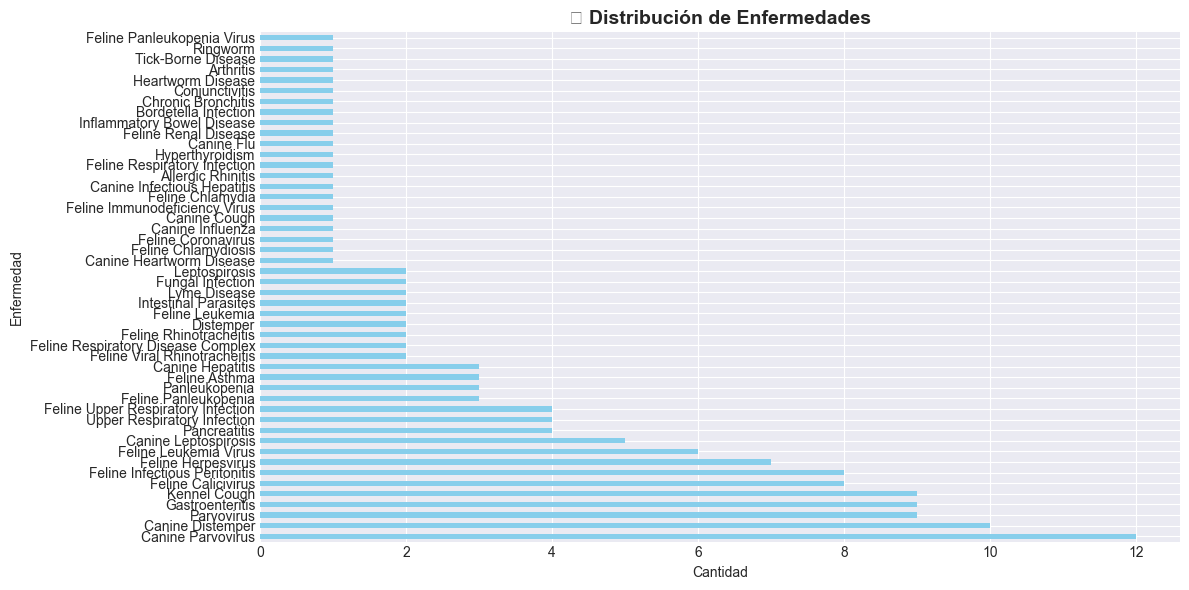

In [10]:
# Visualizar distribución de enfermedades
plt.figure(figsize=(12, 6))
df['Disease_Prediction'].value_counts().plot(kind='barh', color='skyblue')
plt.title('🏥 Distribución de Enfermedades', fontsize=14, fontweight='bold')
plt.xlabel('Cantidad')
plt.ylabel('Enfermedad')
plt.tight_layout()
plt.show()

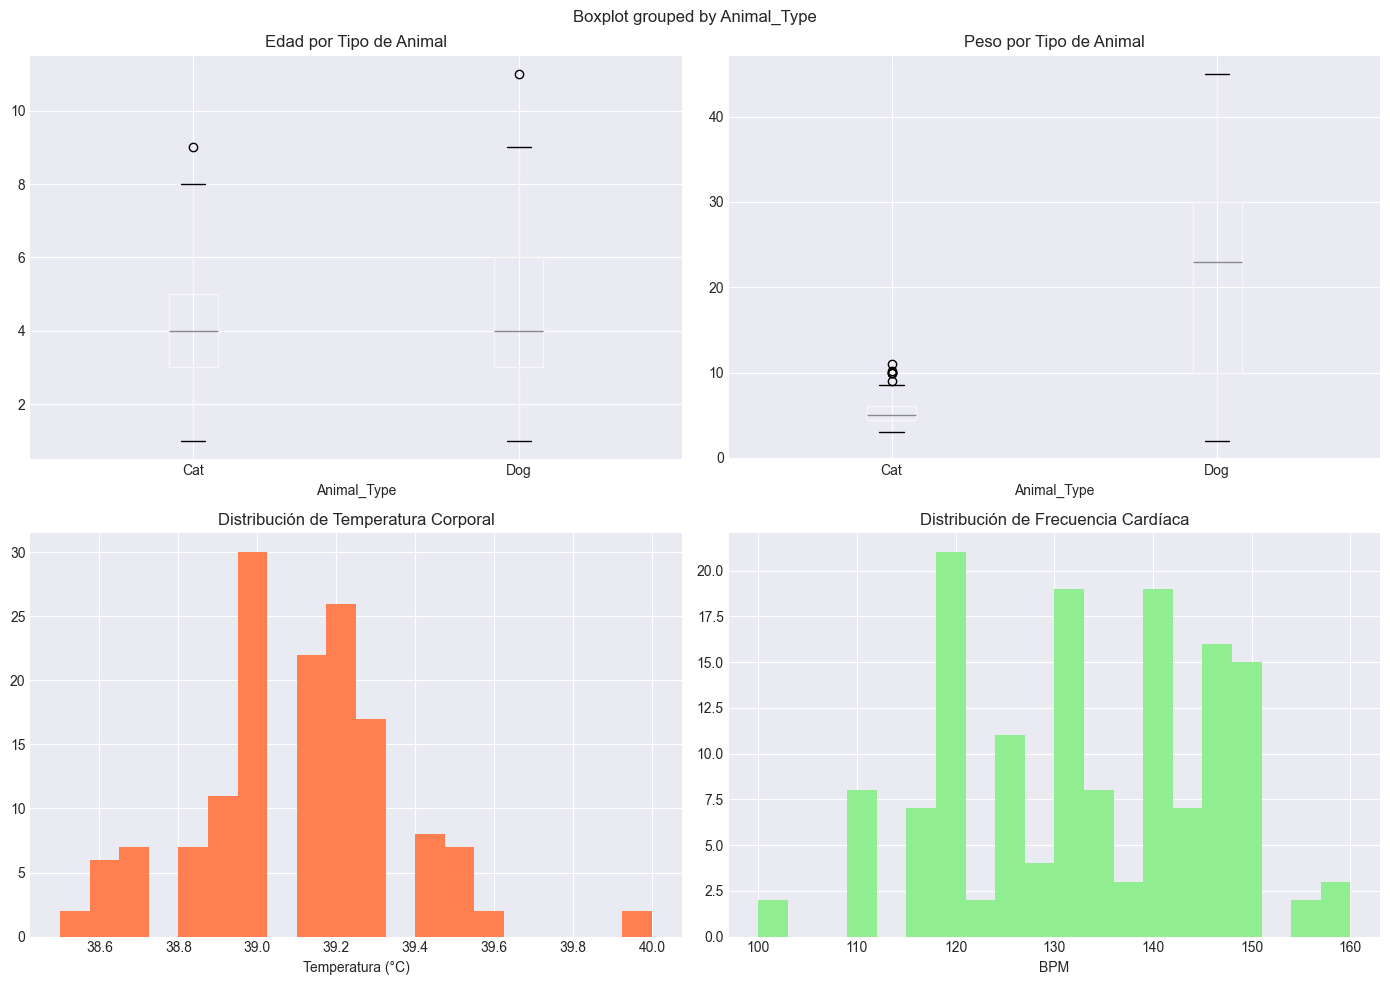

In [11]:
# Correlación de síntomas con enfermedades
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Edad vs Enfermedad
df.boxplot(column='Age', by='Animal_Type', ax=axes[0,0])
axes[0,0].set_title('Edad por Tipo de Animal')

# Gráfico 2: Peso vs Tipo
df.boxplot(column='Weight', by='Animal_Type', ax=axes[0,1])
axes[0,1].set_title('Peso por Tipo de Animal')

# Gráfico 3: Temperatura corporal
df['Body_Temperature'].hist(bins=20, ax=axes[1,0], color='coral')
axes[1,0].set_title('Distribución de Temperatura Corporal')
axes[1,0].set_xlabel('Temperatura (°C)')

# Gráfico 4: Heart Rate
df['Heart_Rate'].hist(bins=20, ax=axes[1,1], color='lightgreen')
axes[1,1].set_title('Distribución de Frecuencia Cardíaca')
axes[1,1].set_xlabel('BPM')

plt.tight_layout()
plt.show()

## 5️⃣ Preparación para PyCaret

### Seleccionar un subset pequeño (10-20% de los datos)

In [13]:
# Primero, verificar la distribución de enfermedades
print('🔍 Verificando distribución de enfermedades...')
disease_counts = df['Disease_Prediction'].value_counts()
print(disease_counts)

# Filtrar solo enfermedades con al menos 10 casos para hacer split estratificado
min_samples = 10
valid_diseases = disease_counts[disease_counts >= min_samples].index
df_filtered = df[df['Disease_Prediction'].isin(valid_diseases)].copy()

print(f'\n✅ Filtrado aplicado:')
print(f'   - Original: {df.shape[0]} registros, {df["Disease_Prediction"].nunique()} enfermedades')
print(f'   - Filtrado: {df_filtered.shape[0]} registros, {df_filtered["Disease_Prediction"].nunique()} enfermedades')
print(f'   - Se eliminaron enfermedades con menos de {min_samples} casos')

# Ahora sí, tomar una muestra estratificada (20% de los datos)
from sklearn.model_selection import train_test_split

df_sample, _ = train_test_split(
    df_filtered, 
    test_size=0.8,  # Tomamos solo el 20%
    stratify=df_filtered['Disease_Prediction'],  # Mantener proporción de clases
    random_state=42
)

print(f'\n✅ Muestra creada: {df_sample.shape}')
print(f'📊 Distribución de enfermedades en la muestra:')
print(df_sample['Disease_Prediction'].value_counts())

🔍 Verificando distribución de enfermedades...
Disease_Prediction
Canine Parvovirus                     12
Canine Distemper                      10
Parvovirus                             9
Gastroenteritis                        9
Kennel Cough                           9
Feline Calicivirus                     8
Feline Infectious Peritonitis          8
Feline Herpesvirus                     7
Feline Leukemia Virus                  6
Canine Leptospirosis                   5
Pancreatitis                           4
Upper Respiratory Infection            4
Feline Upper Respiratory Infection     4
Feline Panleukopenia                   3
Panleukopenia                          3
Feline Asthma                          3
Canine Hepatitis                       3
Feline Viral Rhinotracheitis           2
Feline Respiratory Disease Complex     2
Feline Rhinotracheitis                 2
Distemper                              2
Feline Leukemia                        2
Intestinal Parasites             

### 🔧 Feature Engineering

In [14]:
# Seleccionar features relevantes
features_to_keep = [
    'Animal_Type', 'Age', 'Gender', 'Weight',
    'Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing',
    'Labored_Breathing', 'Lameness', 'Skin_Lesions',
    'Nasal_Discharge', 'Eye_Discharge',
    'Body_Temperature', 'Heart_Rate',
    'Disease_Prediction'  # Target
]

df_ml = df_sample[features_to_keep].copy()

# Eliminar filas con NaN en features importantes
df_ml = df_ml.dropna()

print(f'✅ Dataset ML preparado: {df_ml.shape}')
print(f'\n📋 Columnas finales: {df_ml.columns.tolist()}')
print(f'\n🎯 Target: Disease_Prediction ({df_ml["Disease_Prediction"].nunique()} clases)')

✅ Dataset ML preparado: (4, 16)

📋 Columnas finales: ['Animal_Type', 'Age', 'Gender', 'Weight', 'Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing', 'Labored_Breathing', 'Lameness', 'Skin_Lesions', 'Nasal_Discharge', 'Eye_Discharge', 'Body_Temperature', 'Heart_Rate', 'Disease_Prediction']

🎯 Target: Disease_Prediction (2 clases)


## 6️⃣ PyCaret: Comparación de Algoritmos

### 🚀 Setup de PyCaret

In [18]:
print('⚠️  PyCaret tiene problemas de compatibilidad en este entorno.')
print('🔄 Cambiando a implementación manual con Scikit-Learn...')
print('\n📊 Estado actual del dataset:')
print(f'   - Tamaño: {df_ml.shape}')
print(f'   - Clases: {df_ml["Disease_Prediction"].nunique()}')
print(f'   - Distribución: {dict(df_ml["Disease_Prediction"].value_counts())}')

if df_ml.shape[0] < 20:
    print('\n❌ PROBLEMA: Dataset demasiado pequeño para ML')
    print('   - Solo tenemos', df_ml.shape[0], 'registros')
    print('   - Necesitamos al menos 50-100 registros para entrenar')
    print('\n💡 SOLUCIÓN: Usar dataset completo sin filtrar por cantidad mínima')
    
    # Volver al dataset original completo (solo perros y gatos)
    df_full = df_diseases[df_diseases['Animal_Type'].isin(['Dog', 'Cat'])].copy()
    
    # Limpiar igual que antes
    if 'Body_Temperature' in df_full.columns:
        df_full['Body_Temperature'] = df_full['Body_Temperature'].str.replace('Â°C', '').str.replace('°C', '').astype(float)

    # Convertir variables Yes/No a 1/0
    binary_cols = ['Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing', 
                   'Labored_Breathing', 'Lameness', 'Skin_Lesions', 
                   'Nasal_Discharge', 'Eye_Discharge']

    for col in binary_cols:
        if col in df_full.columns:
            df_full[col] = df_full[col].map({'Yes': 1, 'No': 0})
    
    # Seleccionar features
    features_to_keep = [
        'Animal_Type', 'Age', 'Gender', 'Weight',
        'Appetite_Loss', 'Vomiting', 'Diarrhea', 'Coughing',
        'Labored_Breathing', 'Lameness', 'Skin_Lesions',
        'Nasal_Discharge', 'Eye_Discharge',
        'Body_Temperature', 'Heart_Rate',
        'Disease_Prediction'  # Target
    ]
    
    df_ml_full = df_full[features_to_keep].copy().dropna()
    
    print(f'\n✅ Dataset completo preparado: {df_ml_full.shape}')
    print(f'📊 Distribución de enfermedades:')
    print(df_ml_full['Disease_Prediction'].value_counts().head(10))
    
    # Usar este dataset más grande para ML
    df_ml = df_ml_full.copy()
    
else:
    print('\n✅ Dataset tiene suficientes registros para continuar')

print('\n🚀 Procediendo con comparación manual de algoritmos...')

⚠️  PyCaret tiene problemas de compatibilidad en este entorno.
🔄 Cambiando a implementación manual con Scikit-Learn...

📊 Estado actual del dataset:
   - Tamaño: (4, 16)
   - Clases: 2
   - Distribución: {'Canine Parvovirus': 2, 'Canine Distemper': 2}

❌ PROBLEMA: Dataset demasiado pequeño para ML
   - Solo tenemos 4 registros
   - Necesitamos al menos 50-100 registros para entrenar

💡 SOLUCIÓN: Usar dataset completo sin filtrar por cantidad mínima

✅ Dataset completo preparado: (147, 16)
📊 Distribución de enfermedades:
Disease_Prediction
Canine Parvovirus                12
Canine Distemper                 10
Parvovirus                        9
Gastroenteritis                   9
Kennel Cough                      9
Feline Calicivirus                8
Feline Infectious Peritonitis     8
Feline Herpesvirus                7
Feline Leukemia Virus             6
Canine Leptospirosis              5
Name: count, dtype: int64

🚀 Procediendo con comparación manual de algoritmos...


### 📊 Analizar el mejor modelo

In [ ]:
# Crear y entrenar el mejor modelo
best = create_model(best_models[0])

print(f'\n✅ Mejor modelo: {best}')

In [ ]:
# Evaluar el modelo con gráficos
evaluate_model(best)

### 🔍 Importancia de features

In [ ]:
# Ver importancia de features
plot_model(best, plot='feature')

### 📈 Matriz de confusión

In [ ]:
# Matriz de confusión
plot_model(best, plot='confusion_matrix')

### 🎯 Predicciones de prueba

In [ ]:
# Hacer predicciones en el set de test
predictions = predict_model(best)
display(predictions.head(10))

## 7️⃣ Conclusiones y Próximos Pasos

### 📝 Resumen de resultados

In [ ]:
# Obtener métricas del mejor modelo
from pycaret.classification import pull

results = pull()
print('📊 MÉTRICAS DEL MEJOR MODELO:')
print('='*50)
display(results)

print('\n🎯 CONCLUSIONES:')
print('='*50)
print(f'✅ Dataset usado: Animal Disease Prediction (Dogs & Cats)')
print(f'✅ Muestra: {df_ml.shape[0]} registros')
print(f'✅ Features: {len(df_ml.columns)-1}')
print(f'✅ Clases: {df_ml["Disease_Prediction"].nunique()}')
print(f'\n🏆 Mejor algoritmo encontrado: {best}')
print(f'\n📌 PRÓXIMOS PASOS:')
print('1. Entrenar el modelo manualmente con TODO el dataset')
print('2. Hacer fine-tuning de hiperparámetros')
print('3. Validar con datos reales')
print('4. Integrar en el chat de salud de PawMI')

### 💾 Guardar resultados

In [ ]:
# Guardar el modelo entrenado
save_model(best, '../models/pycaret_best_model')

# Guardar el dataset procesado
df_ml.to_csv('../data/processed/ml_ready_dataset.csv', index=False)

print('✅ Modelo guardado en: models/pycaret_best_model.pkl')
print('✅ Dataset guardado en: data/processed/ml_ready_dataset.csv')